Nesessary libraries connected

In [2]:
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
import numpy as np
import os
import tensorflow as tf
import random
import opendatasets as od

In [3]:
filename = "animals10"
if not os.path.exists(filename):
    print("Downloading the dataset...")
    od.download("https://www.kaggle.com/datasets/alessiocorrado99/animals10")
else:
    print("Dataset file already exists.")

Dataset file already exists.


Categories: ['cane', 'cavallo', 'elefante', 'farfalla', 'gallina', 'gatto', 'mucca', 'pecora', 'ragno', 'scoiattolo']
[[230 230 229 ... 234 235 235]
 [230 230 229 ... 234 234 235]
 [229 229 228 ... 233 234 234]
 ...
 [ 87  86  85 ... 239 239 239]
 [ 86  86  85 ... 239 239 239]
 [ 94  87  82 ... 240 240 239]]


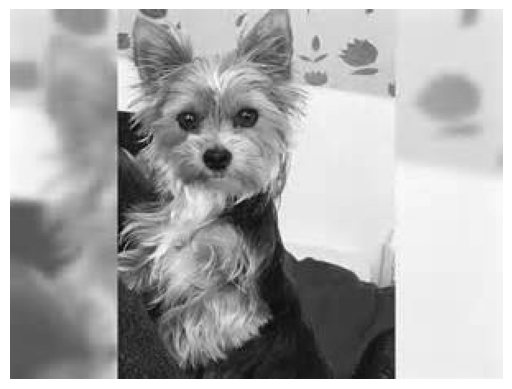

In [4]:
directory = 'animals10/raw-img'

categories = [folder for folder in os.listdir(directory) if os.path.isdir(os.path.join(directory, folder))]

print("Categories:", categories)

for cl in categories:
    path = os.path.join(directory, cl)
    for img_path in os.listdir(path):
        img = cv2.imread(os.path.join(path, img_path), cv2.IMREAD_GRAYSCALE)
        plt.imshow(img, cmap="gray")
        plt.axis('off')
        break
    break

print(img)

In [47]:
def image_preprocessing(img):
    img = cv2.GaussianBlur(img, (3, 3), 0) #Removing noise from the pictures (increased accuracy by 1 percent)
    img_blurred = cv2.medianBlur(img, 3)
    img_gray = cv2.cvtColor(img_blurred, cv2.COLOR_BGR2GRAY)
    resized = cv2.resize(img_gray, (128,128))
    normalized = resized/255.0
    sobel_x = cv2.Sobel(normalized, cv2.CV_64F, 1, 0, ksize=3)  # Sobel in x direction
    sobel_y = cv2.Sobel(normalized, cv2.CV_64F, 0, 1, ksize=3)  # Sobel in y direction
    sobel_magnitude = cv2.magnitude(sobel_x, sobel_y)
    return sobel_magnitude

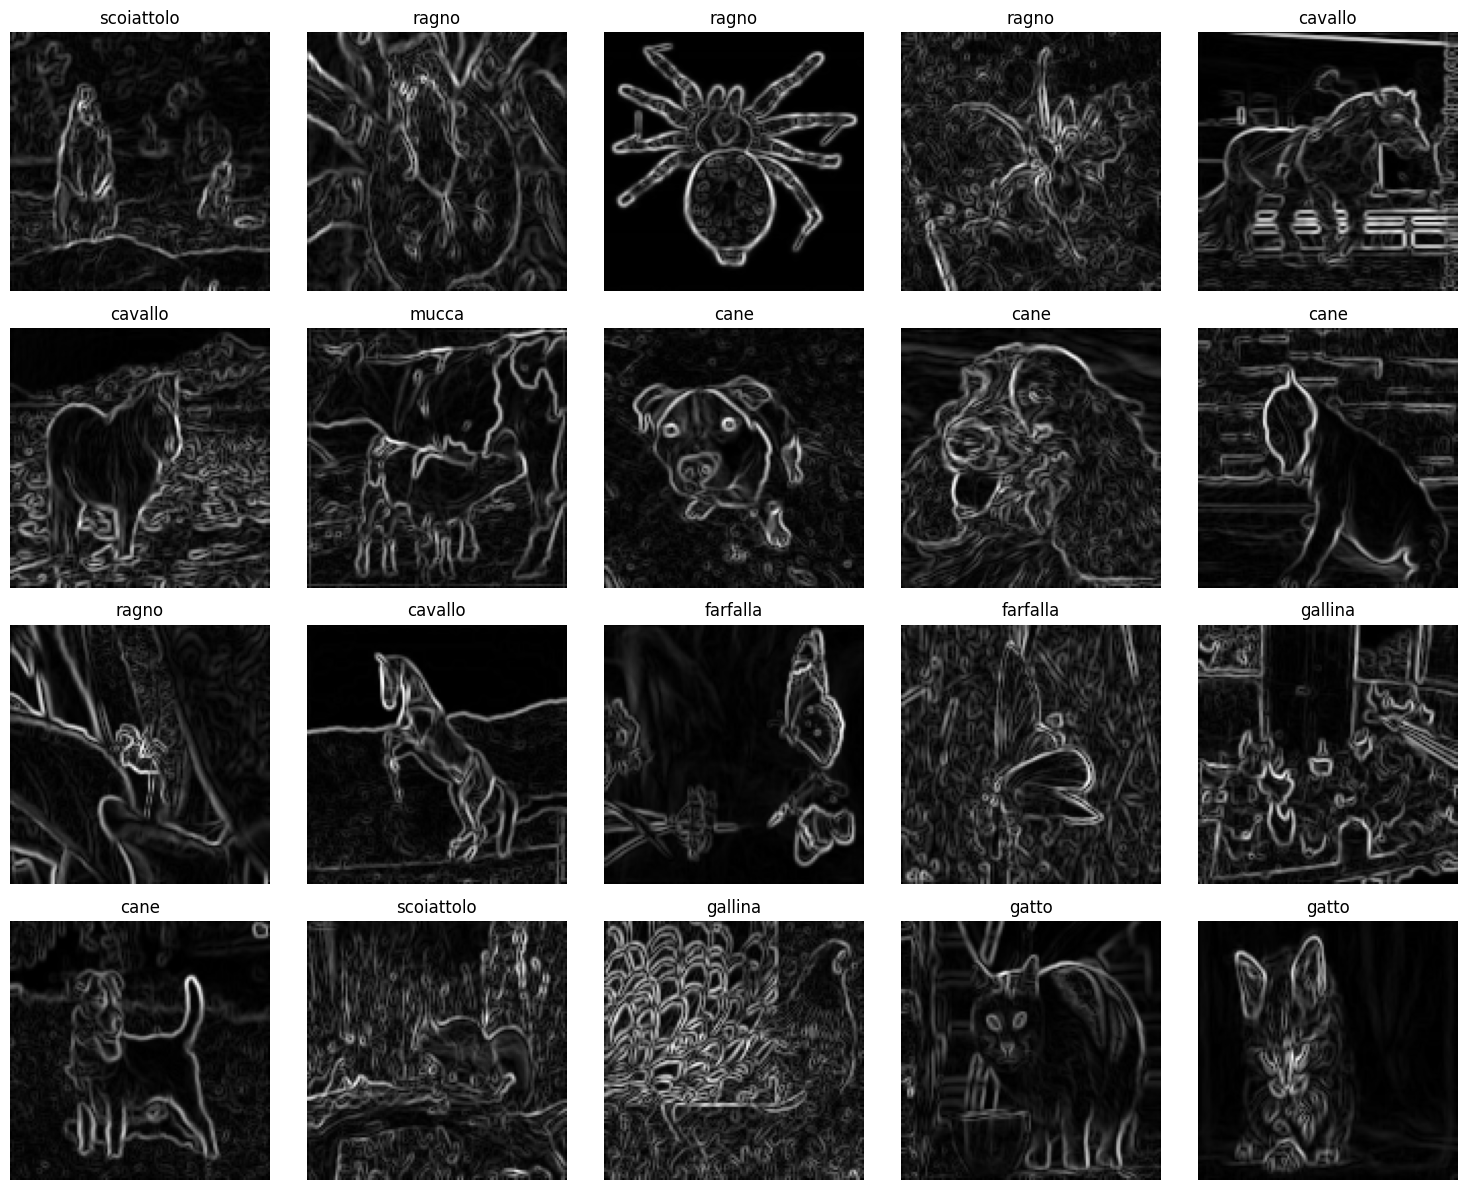

In [48]:
animals = []
for cl in categories:
    cls_num = categories.index(cl)
    path = os.path.join(directory, cl)
    for img in os.listdir(path):
        try:
            img = cv2.imread(os.path.join(path, img))
            preprocessed_image = image_preprocessing(img)  # Apply preprocessing
            if preprocessed_image is not None:
                animals.append([preprocessed_image, cls_num])  # Add only [image, label]
        except Exception as e:
            print(f"Error processing image: {e}")

random.shuffle(animals)

# Display Images
num_display = min(20, len(animals))
num_rows = (num_display + 4) // 5
plt.figure(figsize=(15, num_rows * 3))
for i, (img, cls_num) in enumerate(animals[:num_display]):
    plt.subplot(num_rows, 5, i + 1)
    plt.imshow(img, cmap='gray')  # Display grayscale image
    plt.title(categories[cls_num])
    plt.axis('off')
plt.tight_layout()
plt.show()

In [68]:
x = []
y = []

for idx, (pic, label) in enumerate(animals):
    resized_pic = cv2.resize(pic, (128, 128))
    x.append(resized_pic)
    y.append(label)

x = np.array(x)/255.0
y = np.array(y)
x_train_val, x_test, y_train_val, y_test = train_test_split(x, y, test_size=0.2)
x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, test_size = 0.2, random_state = 0)
print(f"Images length: {len(x)}")
print(f"Labels length: {len(y)}")

Images length: 26179
Labels length: 26179


In [69]:
# Define a CustomConv2D layer to handle multiple filters
class CustomConv2D(tf.keras.layers.Layer):
    def __init__(self, filters, kernel_size, kernel_initializer=None, padding="valid", activation=None, **kwargs):
        super(CustomConv2D, self).__init__(**kwargs)
        self.filters = filters
        self.kernel_size = kernel_size
        self.padding = padding
        self.activation = tf.keras.activations.get(activation)
        self.kernel_initializer = kernel_initializer

    def build(self, input_shape):
        # Use predefined kernels if provided, otherwise initialize normally
        kernel_shape = (*self.kernel_size, input_shape[-1], self.filters)
        if self.kernel_initializer is not None:
            self.kernel = self.add_weight(name="kernel",
                                          shape=kernel_shape,
                                          initializer=tf.constant_initializer(self.kernel_initializer),
                                          trainable=True)
        else:
            self.kernel = self.add_weight(name="kernel",
                                          shape=kernel_shape,
                                          initializer="glorot_uniform",
                                          trainable=True)


        # Initialize biases for each filter
        self.bias = self.add_weight(name="bias",
                                    shape=(self.filters,),
                                    initializer="zeros",
                                    trainable=True)

    def call(self, inputs):
        # Perform the convolution using multiple filters
        output = tf.nn.conv2d(inputs, self.kernel, strides=1, padding=self.padding.upper())
        # Add bias and apply the activation function, if specified
        output = tf.nn.bias_add(output, self.bias)
        if self.activation is not None:
            output = self.activation(output)
        return output

# Define example filters

sobel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])

sobel_y = np.array([[-1, -2, -1],[ 0,  0,  0],[ 1,  2,  1]])

sharpening_filter = np.array([[ 0, -1,  0],[-1,  5, -1],[ 0, -1,  0]])  # Horizontal edge

# Stack the filters to shape (3, 3, 1, 3) for compatibility with CustomConv2D
predefined_kernels = np.stack([sobel_x, sobel_y, sharpening_filter], axis=-1)
predefined_kernels = np.expand_dims(predefined_kernels, axis=-2)  # Shape (3, 3, 1, 3)

# Define the CNN model with the CustomConv2D layer

model = tf.keras.Sequential([
    CustomConv2D(filters=3, kernel_size=(3, 3), kernel_initializer=predefined_kernels, padding="same", activation="relu", input_shape=(128, 128, 1)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(10, activation="softmax")
])

# Compile the model
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Model summary to verify setup
model.summary()

# Train the model (optional, requires the full dataset and a longer training process)
model.fit(x_train, y_train, epochs=5, validation_data=(x_val, y_val))

# Evaluate the model (optional)
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"Test accuracy: {test_acc}")

C:\Users\bprid\AppData\Local\Temp\ipykernel_5528\2598152135.py:4: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super(CustomConv2D, self).__init__(**kwargs)


Model: "sequential_40"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ custom_conv2d_39 (CustomConv2D) │ (None, 128, 128, 3)    │            30 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_53 (MaxPooling2D) │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_40 (Flatten)            │ (None, 12288)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_48 (Dense)                │ (None, 10)             │       122,890 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 122,920 (480.16 KB)

 Trainable params: 122,920 (480.16 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
524/524 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.2164 - loss: 2.1893 - val_accuracy: 0.2905 - val_loss: 2.0262
Epoch 2/5
524/524 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.3112 - loss: 1.9920 - val_accuracy: 0.2979 - val_loss: 1.9881
Epoch 3/5
524/524 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.3335 - loss: 1.9232 - val_accuracy: 0.3187 - val_loss: 1.9774
Epoch 4/5
524/524 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.3584 - loss: 1.8667 - val_accuracy: 0.3127 - val_loss: 1.9619
Epoch 5/5
524/524 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.3838 - loss: 1.8167 - val_accuracy: 0.3435 - val_loss: 1.9340
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3503 - loss: 1.9128
Test accuracy: 0.34835752844810486


data augmentation